In [1]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mainpath = "/home/ubuntu/simulations/classificator_features/"

folder_name = os.listdir(mainpath)[0]
abs_path = mainpath + folder_name

In [3]:
folder_name

'nnet_sheaf_PubMed_realization_25_embed_dime_1_dimy_16'

In [4]:
features_result = {}
for file in os.listdir(abs_path):
    features_result[file.split('.')[0]] = np.load(abs_path + '/' + file)

In [5]:
features_result.keys()

dict_keys(['idx_test', 'test_features', 'test_labels', 'train_labels', 'labels', 'features', 'val_labels', 'idx_valid', 'idx_train', 'train_features', 'val_features'])

In [6]:
features_result['train_features'].shape, features_result['train_labels'].shape, features_result['features'].shape

((11831, 500), (11831,), (19717, 500))

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')  # или 'seaborn-white'

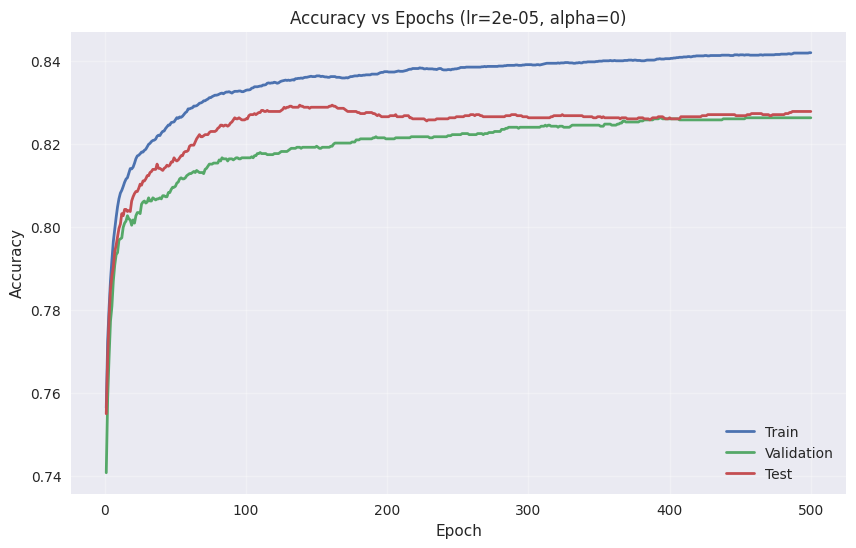

Best val epoch Test Accuracy: 0.8265


In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

def train_logistic_regression_with_tracking(features_result, n_epochs=100, learning_rate=0.01, 
                                         alpha=0.0001, scale_features=True, random_state=42, model_name='test'):
   os.makedirs('logreg_plots', exist_ok=True)
   X_train = features_result['train_features']
   y_train = features_result['train_labels']
   X_val = features_result['val_features']
   y_val = features_result['val_labels']
   X_test = features_result['test_features']
   y_test = features_result['test_labels']
   
   scaler = None
   if scale_features:
       scaler = StandardScaler()
       X_train = scaler.fit_transform(X_train)
       X_val = scaler.transform(X_val)
       X_test = scaler.transform(X_test)
   
   model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=learning_rate,
                        alpha=alpha, max_iter=1, warm_start=True, random_state=random_state)
   
   train_accs = []
   val_accs = []
   test_accs = []
   
   for i in range(n_epochs):
       model.partial_fit(X_train, y_train, classes=np.unique(y_train))
       
       train_acc = accuracy_score(y_train, model.predict(X_train))
       val_acc = accuracy_score(y_val, model.predict(X_val))
       test_acc = accuracy_score(y_test, model.predict(X_test))
       
       train_accs.append(train_acc)
       val_accs.append(val_acc)
       test_accs.append(test_acc)
   
   plt.figure(figsize=(10, 6))
   plt.plot(range(1, n_epochs + 1), train_accs, label='Train', linewidth=2)
   plt.plot(range(1, n_epochs + 1), val_accs, label='Validation', linewidth=2)
   plt.plot(range(1, n_epochs + 1), test_accs, label='Test', linewidth=2)
   plt.xlabel('Epoch')
   plt.ylabel('Accuracy')
   plt.legend()
   plt.grid(True, alpha=0.3)
   plt.savefig(f'logreg_plots/{model_name}.png', dpi=300, bbox_inches='tight')
   plt.title(f'Accuracy vs Epochs (lr={learning_rate}, alpha={alpha})')
   plt.show()

   best_index = np.argmax(val_accs)
   
   return model, {
       'train_accs': train_accs,
       'val_accs': val_accs,
       'test_accs': test_accs,
       'final_train_acc': train_accs[best_index],
       'final_val_acc': val_accs[best_index],
       'final_test_acc': test_accs[best_index],
       'scaler': scaler
   }

def hyperparameter_search(features_result, param_grid=None):
   if param_grid is None:
       param_grid = {
           'learning_rate': [0.001, 0.01, 0.1],
           'alpha': [0.0001, 0.001, 0.01],
           'n_epochs': [50, 100, 200]
       }
   
   best_val_acc = 0
   best_params = None
   best_results = None
   
   scaler = StandardScaler()
   X_train = scaler.fit_transform(features_result['train_features'])
   X_val = scaler.transform(features_result['val_features'])
   X_test = scaler.transform(features_result['test_features'])
   y_train = features_result['train_labels']
   y_val = features_result['val_labels']
   y_test = features_result['test_labels']
   
   scaled_features = {
       'train_features': X_train,
       'val_features': X_val,
       'test_features': X_test,
       'train_labels': y_train,
       'val_labels': y_val,
       'test_labels': y_test
   }
   
   for params in ParameterGrid(param_grid):
       print(f"Testing params: {params}")
       
       model, results = train_logistic_regression_with_tracking(
           scaled_features,
           n_epochs=params['n_epochs'],
           learning_rate=params['learning_rate'],
           alpha=params['alpha'],
           scale_features=False
       )
       
       if results['final_val_acc'] > best_val_acc:
           best_val_acc = results['final_val_acc']
           best_params = params
           best_results = results
           print(f"New best val accuracy: {best_val_acc:.4f}")
   
   print(f"\nBest parameters: {best_params}")
   print(f"Best validation accuracy: {best_val_acc:.4f}")
   print(f"Test accuracy with best params: {best_results['final_test_acc']:.4f}")
   
   return best_params, best_results

model, results = train_logistic_regression_with_tracking(features_result, learning_rate=0.00002, alpha=0, n_epochs=500)
print(f"Best val epoch Test Accuracy: {results['final_test_acc']:.4f}")

In [21]:
print('original accuracies')

for part in ['train', 'valid', 'ttest']:
    print(part, np.load(f"/home/ubuntu/simulations/results/accs_{part}_" + '_'.join(folder_name.split('_')[2:]) + '.npy'))

original accuracies
train 0.7649395655481362
valid 0.7506974384986052
ttest 0.75754501648491


  0%|          | 0/11 [00:00<?, ?it/s]

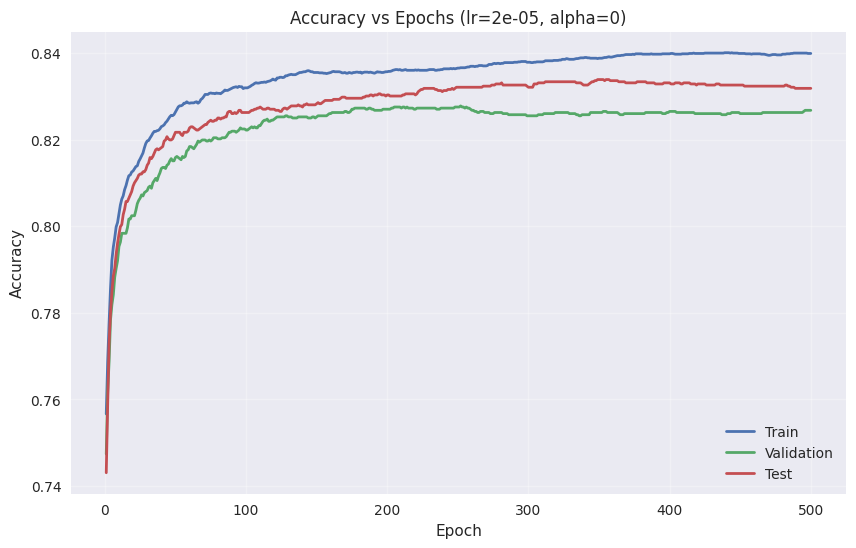

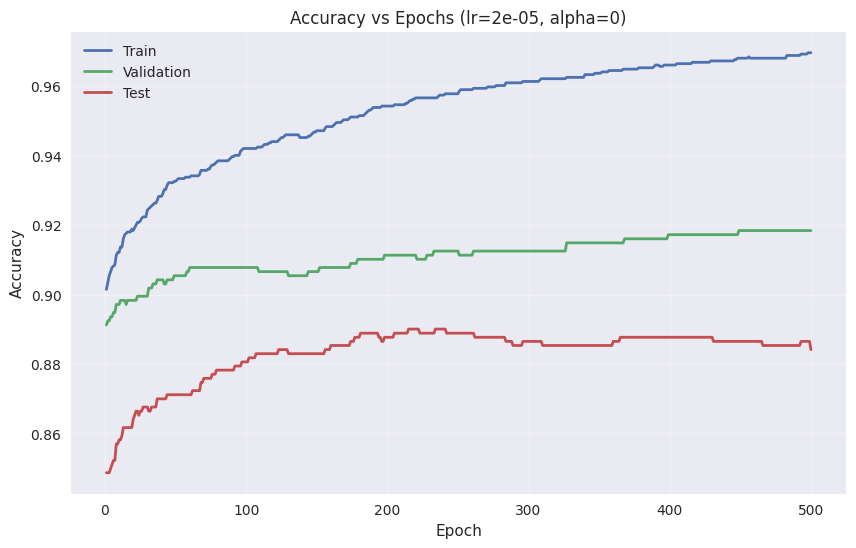

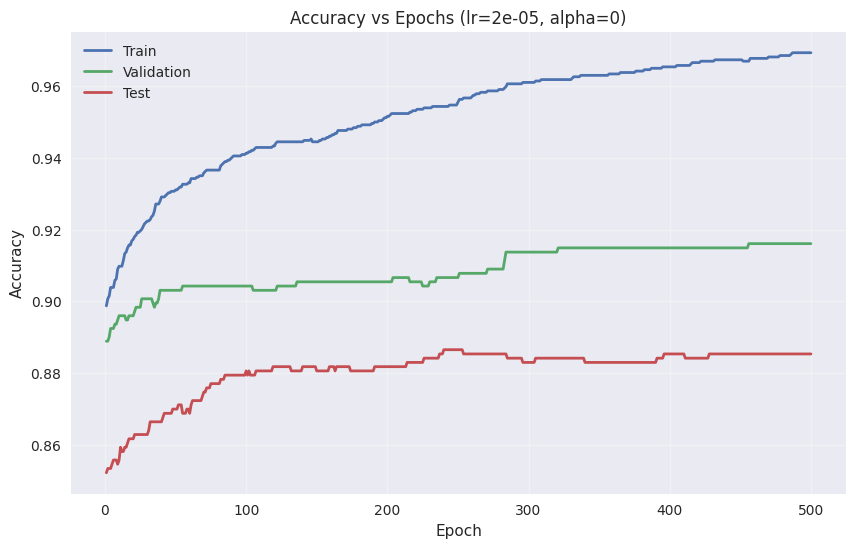

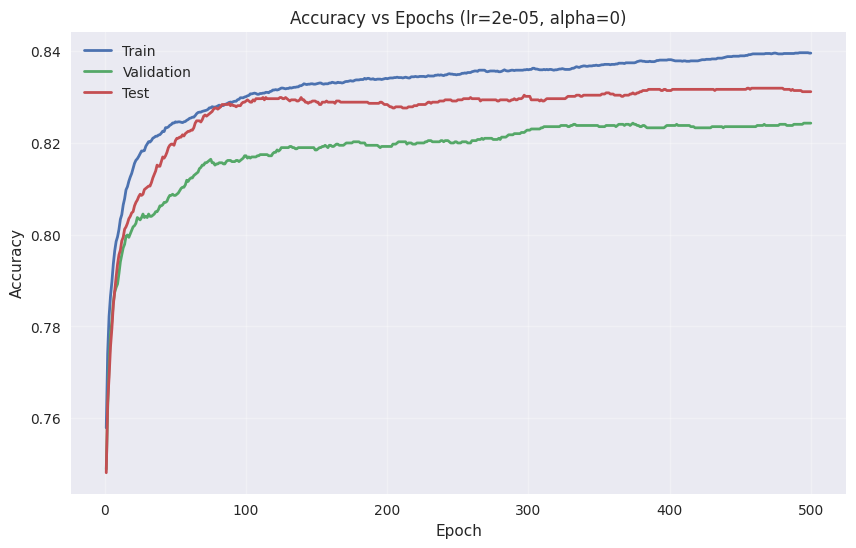

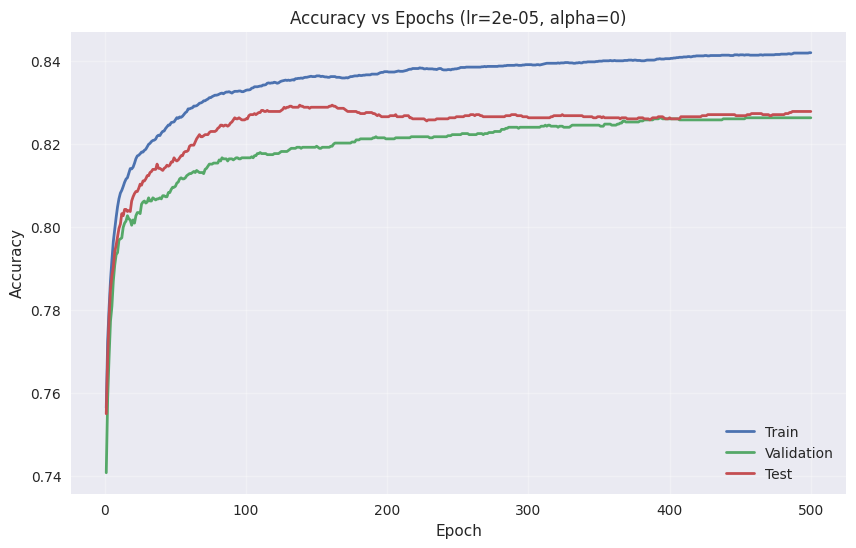

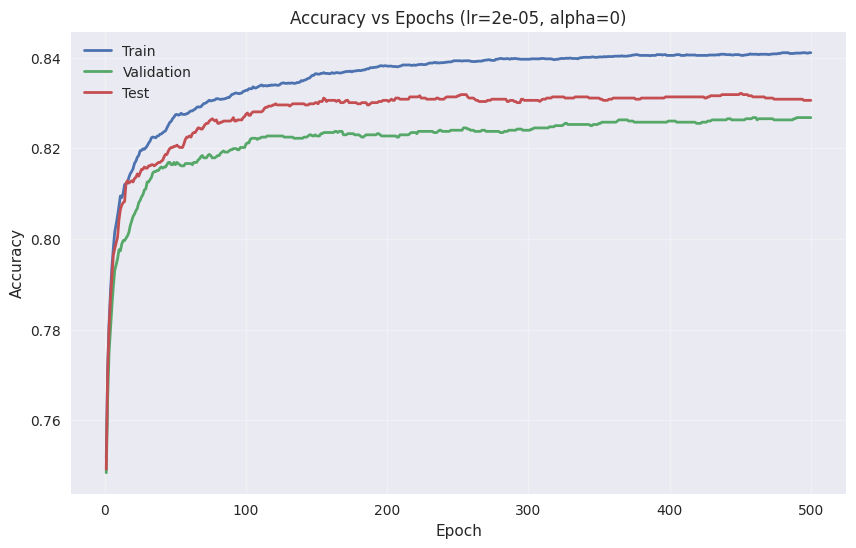

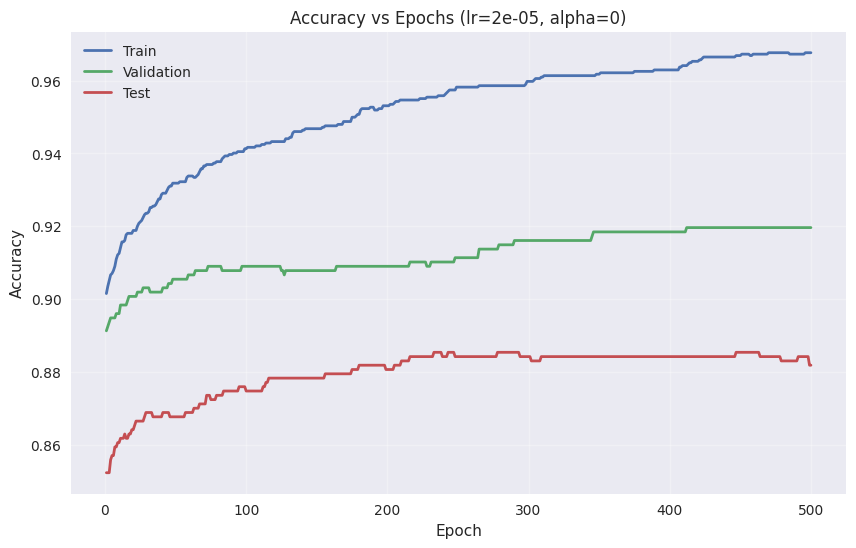

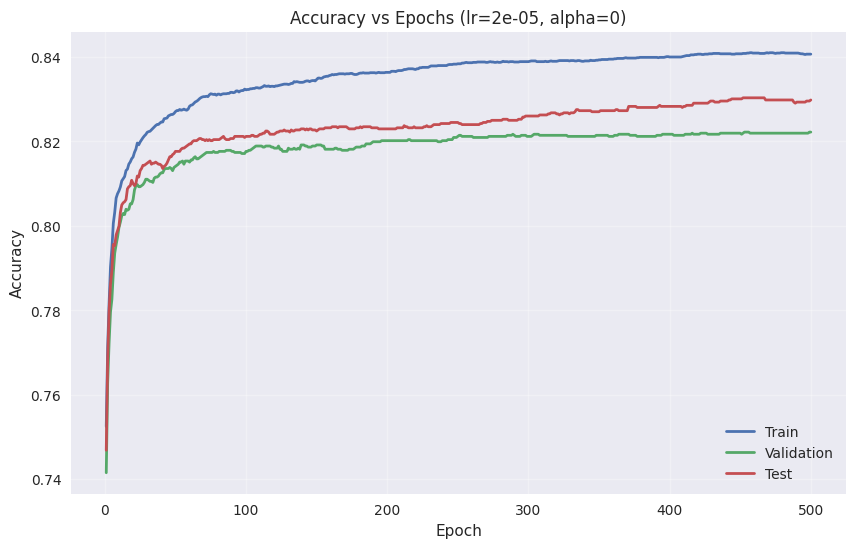

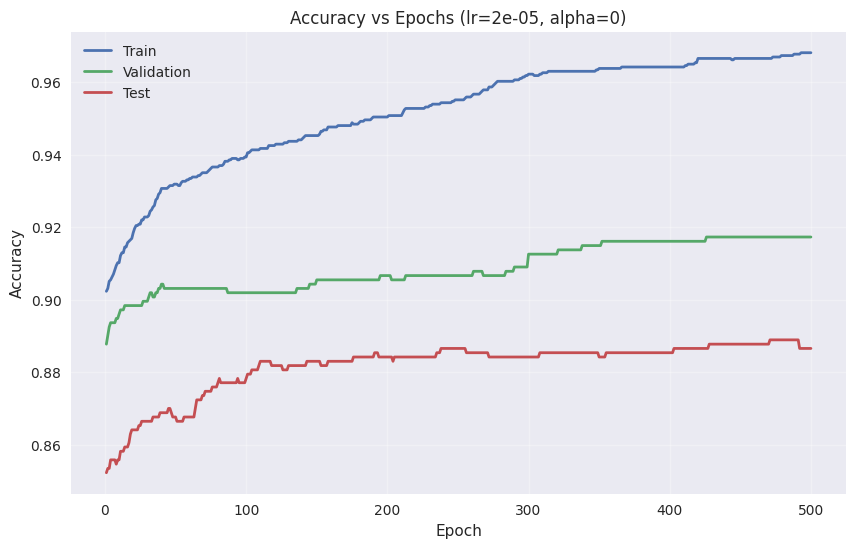

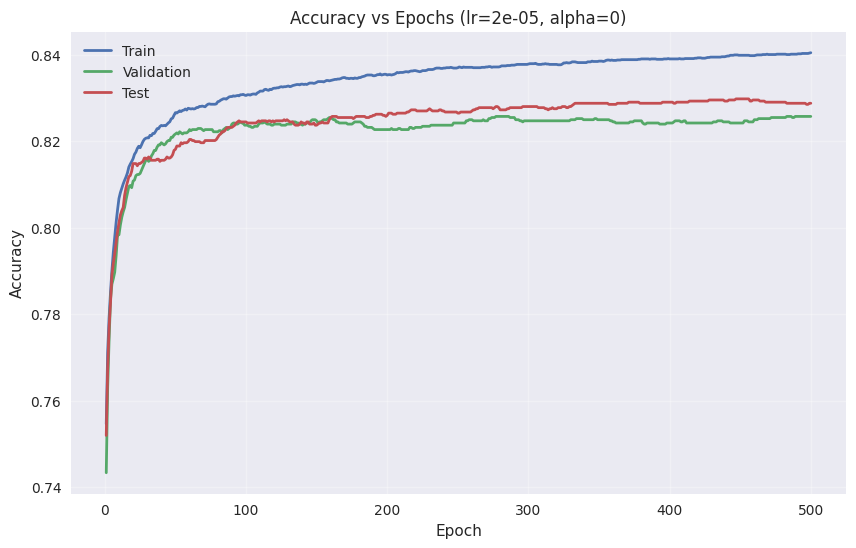

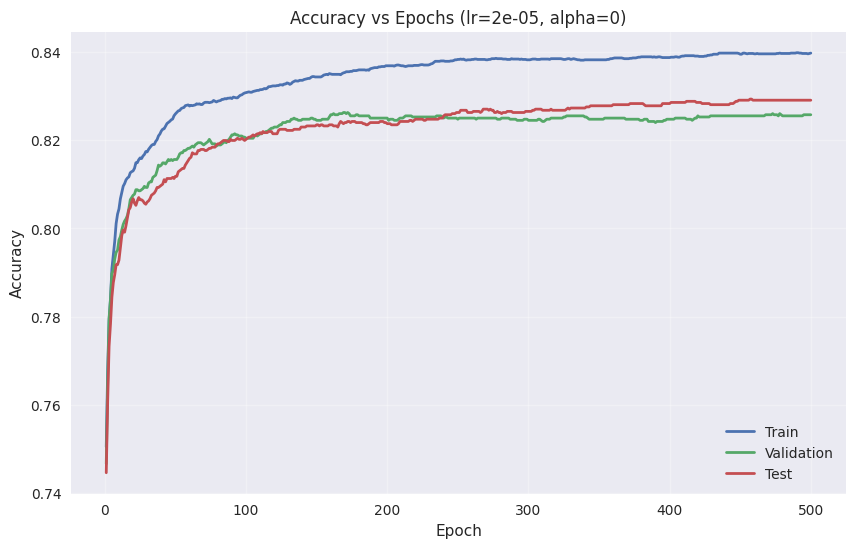

In [29]:
from tqdm.notebook import tqdm
import pandas as pd

all_exp_results = []

for folder_name in tqdm(os.listdir(mainpath)):
    cur_result = {'model_name': folder_name}
    abs_path = mainpath + folder_name
    features_result = {}
    for file in os.listdir(abs_path):
        features_result[file.split('.')[0]] = np.load(abs_path + '/' + file)
    _, results = train_logistic_regression_with_tracking(features_result, learning_rate=0.00002, alpha=0, n_epochs=500, model_name=folder_name)

    for key in ['final_train_acc', 'final_val_acc', 'final_test_acc']:
        cur_result['LogReg_' + key] = results[key]

    for part in ['train', 'valid', 'ttest']:
        cur_result[f'baseline_{part}'] =  np.load(f"/home/ubuntu/simulations/results/accs_{part}_" + '_'.join(folder_name.split('_')[2:]) + '.npy').item()
    
    all_exp_results.append(cur_result)

all_exp_results = pd.DataFrame(all_exp_results)

In [35]:
all_exp_results['dataset_name'] = all_exp_results.model_name.apply(lambda x: x.split('_')[2])

In [40]:
all_exp_results[all_exp_results.dataset_name == 'CiteSeer'].drop(columns=['model_name', 'dataset_name']).mean()

LogReg_final_train_acc    0.966411
LogReg_final_val_acc      0.917849
LogReg_final_test_acc     0.885638
baseline_train            0.744779
baseline_valid            0.725768
baseline_ttest            0.740544
dtype: float64

In [39]:
all_exp_results[all_exp_results.dataset_name == 'PubMed'].drop(columns=['model_name', 'dataset_name']).mean()

LogReg_final_train_acc    0.838367
LogReg_final_val_acc      0.825622
LogReg_final_test_acc     0.828992
baseline_train            0.761993
baseline_valid            0.758088
baseline_ttest            0.759465
dtype: float64